Тут в сааамом конце подобие нейросетки с нормальным выводом метрик. <br>
Остальное просто проверка забвной теории и результаты. Без подбора параметров на том, что есть.

In [ ]:
!pip install catboost

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import Pool, CatBoostClassifier, CatBoostRegressor

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm, notebook

In [3]:
RAND = sum(ord(x) for x in 'NEVER SURRENDER')


from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [4]:
from google.colab import output
output.enable_custom_widget_manager()

_________________________________
Фукнции


In [5]:
def metrics_(real, pred):
    print(f'RMSE = {mean_squared_error(real, pred)**.5}')
    print(f'R2 = {r2_score(real, pred)}')
    print(f'MAE = {mean_absolute_error(real, pred)}')

In [6]:
class LocationCategory(BaseEstimator, TransformerMixin):

    def __init__(self, name_of_column, number_of_category):
        self.location_dict = None
        self.name_of_column = name_of_column
        self.number_of_category = number_of_category

    def fit(self, features, y=None):
        self.location_dict = self.create_dict(features[self.name_of_column])
        return self

    def transform(self, features):
        feature = features.copy()
        feature[self.name_of_column] = feature[self.name_of_column].apply(lambda x: self.location_dict.get(x, -1))
        return feature

    def create_dict(self, feature):

        # create groups by value counts
        groups = feature.value_counts()
        # split by ~equals sum per group
        group_sum = round(groups.sum() / self.number_of_category)

        current_sum = 0
        group_num = 0
        group_dict = {}

        for index, itm in zip(groups.index, groups.to_numpy()):
            if (current_sum + itm) > group_sum:
                if abs(current_sum + itm - group_sum) < abs(current_sum - group_sum):
                    # include current itm in group
                    current_sum = 0
                    rem_sum = groups.loc[index:].sum() - itm
                    group_dict[index] = group_num
                    group_num += 1
                    if group_num == (self.number_of_category - 1):
                        break
                else:
                    # exclude current itm
                    group_num += 1
                    rem_sum = groups.loc[index:].sum()
                    if group_num == (self.number_of_category - 1):
                        break
                    current_sum = itm
                    group_dict[index] = group_num

                # refresh group sum
                group_sum = round(rem_sum / (self.number_of_category - group_num))

            else:
                current_sum += itm
                group_dict[index] = group_num
        return group_dict


# pd.Series
class TextClear(BaseEstimator, TransformerMixin):

    def fit(self, feature, y=None):
        return self

    def transform(self, feature, y=None):
        feature = feature.str.replace(r'((https?:\/\/)|w{3}).*?( |$)', ' ', regex=True)
        feature = feature.str.replace(r'[^A-Za-z\']', ' ', regex=True).str.lower().str.strip()
        feature = feature.str.replace(r'\W{2,}', ' ', regex=True)
        return feature


# pd.Series
class TextLemma(BaseEstimator, TransformerMixin):
    # spacy
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, feature, y=None):
        return self

    def transform(self, feature, y=None):
        return feature.apply(lambda row: ' '.join([w.lemma_ for w in self.nlp(row) if not w.is_stop]))


class WordsNumber(BaseEstimator, TransformerMixin):

    def __init__(self, name_of_column):
        self.name_of_column = name_of_column
        
    def fit(self, features, y=None):
        return self

    def transform(self, features, y=None):
        data = features.copy()
        data['word_num'] = data[self.name_of_column].str.count(' ')
        return data


## Решение через классификацию


Для чистоты эксперименты обработка признаков не меняется, работа только с целевым.

Проблемы того, что ошибка в классификации может "штрафовать" больше, чем аналогичная в регрессии ясна. Но все равно попробовать можно

In [7]:
df = pd.read_csv('tocolab.csv', index_col=[0]).reset_index(drop='True')
df.columns = df.columns.str.replace('(.)([A-Z])', r'\1_\2', regex=True).str.lower()

**Формирование категорий**





In [8]:
df['salary_log'] = np.log1p(df['salary_normalized']) # 

In [ ]:
#df.loc[df['salary_log'] > 120_000, 'salary_log']  = 120_000
# останки от варианта без логарифма

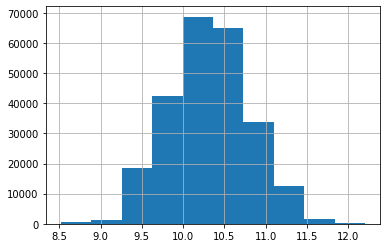

In [9]:
df['salary_log'].hist();

In [10]:
df['q_val'] = pd.qcut(df['salary_log'], 20)
df['q_val'] = df['q_val'].apply(lambda x: x.mid)

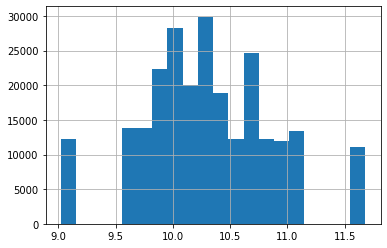

In [11]:
df['q_val'].hist(bins=20);

In [12]:
df['val'] = pd.cut(df['salary_log'], 20)
df['val'] = df['val'].apply(lambda x: x.mid)

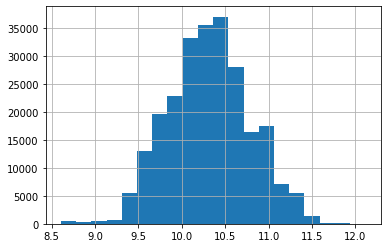

In [13]:
df['val'].hist(bins=20);

Посмотрим метрики, как новый признак будет предсказывать целевой.
(было несколько вариантов разбиения, 5-10-20)

In [14]:
metrics_(np.expm1(df['val'].astype('float')),  df['salary_normalized'])

RMSE = 2060.6993251588
R2 = 0.9866695934132989
MAE = 1555.9225649898005


In [15]:
metrics_(df['q_val'],  df['salary_log'])

RMSE = 0.12219244669235631
R2 = 0.9526466727958853
MAE = 0.05777777724905601


### CatBoost


In [20]:
df['full_description'] = TextClear().transform(df['full_description'])

In [21]:
test = df.tail(2000).reset_index(drop=True)
df = df[:-2000].reset_index(drop=True)

In [22]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=RAND, stratify=df['val'])
print(df_train.shape,df_valid.shape)

(194214, 7) (48554, 7)


In [411]:
X_train = df_train[['full_description','location_normalized','category']]
X_valid = df_valid[['full_description','location_normalized','category']]
X_train[['location_normalized','category']] = X_train[['location_normalized','category']].astype('category')
X_valid[['location_normalized','category']] = X_valid[['location_normalized','category']].astype('category')

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [412]:
cat_le = LabelEncoder()

In [413]:
y_train = cat_le.fit_transform(df_train['val'])
y_valid = cat_le.transform(df_valid['val'])

In [414]:
X_test = test[['full_description','location_normalized','category']]

In [415]:
text_features = ['full_description']
cat_features = list(X_train.columns)
train_pool = Pool(
    X_train, 
    y_train, 
    cat_features=cat_features, 
    text_features=text_features
)
val_pool = Pool(
    X_valid, 
    y_valid, 
    cat_features=cat_features, 
    text_features=text_features
)

In [146]:
catboost_params = {
    'iterations': 20_000,
    'loss_function': 'MultiClass',
    'verbose': 1000,
    'random_state': RAND,
    'depth': 6, 
    'learning_rate': 0.1,
    'auto_class_weights': 'Balanced',
    'eval_metric': 'TotalF1',
    'bootstrap_type':'Bernoulli',
    'leaf_estimation_method': 'Gradient'
}
                     
#  'one_hot_max_size': 30
#     

In [147]:
cat_class_model = CatBoostClassifier(**catboost_params , task_type='GPU')
cat_class_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	learn: 0.1424917	test: 0.1373536	best: 0.1373536 (0)	total: 127ms	remaining: 42m 22s
1000:	learn: 0.6499512	test: 0.3768445	best: 0.3768445 (1000)	total: 1m 16s	remaining: 24m 13s
2000:	learn: 0.7241784	test: 0.4023447	best: 0.4024142 (1993)	total: 2m 45s	remaining: 24m 47s
3000:	learn: 0.7744183	test: 0.4161282	best: 0.4163942 (2986)	total: 4m 23s	remaining: 24m 50s
4000:	learn: 0.8108306	test: 0.4280895	best: 0.4281021 (3991)	total: 5m 52s	remaining: 23m 30s
5000:	learn: 0.8389325	test: 0.4330997	best: 0.4331583 (4997)	total: 7m 13s	remaining: 21m 40s
6000:	learn: 0.8612016	test: 0.4364181	best: 0.4376643 (5899)	total: 8m 32s	remaining: 19m 56s
7000:	learn: 0.8798190	test: 0.4412776	best: 0.4413321 (6888)	total: 10m	remaining: 18m 35s
8000:	learn: 0.8949362	test: 0.4422289	best: 0.4442770 (7754)	total: 11m 34s	remaining: 17m 21s
9000:	learn: 0.9078969	test: 0.4453572	best: 0.4456388 (8928)	total: 12m 51s	remaining: 15m 42s
10000:	learn: 0.9184946	test: 0.4478890	best: 0.4478890 (1

In [150]:
pred = cat_le.inverse_transform(cat_class_model.predict(X_test).ravel())

Разбиение на 20 и логарифм. MAE прям неплох.

In [151]:
metrics_(test['salary_normalized'], np.expm1(pred))

RMSE = 9992.78369188969
R2 = 0.546725655311064
MAE = 5647.861575830578


без логарифма <br>
на 10
- RMSE = 11675.832669107587
- R2 = 0.6593639975636454
- MAE = 7819.042<br>

на 20
- RMSE = 11634.556632393647
- R2 = 0.5385808057042745
- MAE = 7152.07925



В общем и целом неплохо и забавно. Возможно, если тщательно подобрать разбиение и гиперпараметры, то RMSE будет лучше, чем у регрессии.

___________________

In [ ]:
qcat_le = LabelEncoder()
qy_train = qcat_le.fit_transform(df_train['q_val'])
qy_valid = qcat_le.transform(df_valid['q_val'])

In [ ]:
qtrain_pool = Pool(
    X_train, 
    qy_train, 
    cat_features=cat_features, 
    text_features=text_features
)
qval_pool = Pool(
    X_valid, 
    qy_valid, 
    cat_features=cat_features, 
    text_features=text_features
)

In [ ]:
qcat_class_model = CatBoostClassifier(**catboost_params, task_type='GPU')
qcat_class_model.fit(qtrain_pool, eval_set=qval_pool, use_best_model=True)

In [ ]:
qpred = qcat_class_model.predict(X_test)

In [ ]:
metrics_(test['salary_normalized'], qpred)

RMSE = 13294.471761828181
R2 = 0.19771192442591035
MAE = 7316.766044433593


Эта часть была на признаке без логарифма. Не очень удачно получилось :) 


_________________________

Регрессия с "урезанным" целевым

In [ ]:
ry_train = df_train['val']
ry_valid = df_valid['val']


In [ ]:
rtrain_pool = Pool(
    X_train, 
    ry_train, 
    cat_features=cat_features, 
    text_features=text_features
)
rval_pool = Pool(
    X_valid, 
    ry_valid, 
    cat_features=cat_features, 
    text_features=text_features
)

In [ ]:
rcatboost_params = {
    'iterations': 20_000,
    'eval_metric': 'RMSE',
    'verbose': 1000,
    'random_state': RAND,
    'depth': 4, 
    'learning_rate': 0.2
}
#  'one_hot_max_size': 30

In [ ]:
model = CatBoostRegressor(**rcatboost_params, task_type="GPU")
model.fit(rtrain_pool, eval_set=rval_pool, early_stopping_rounds=20, use_best_model=True)

0:	learn: 17187.6277777	test: 17181.8828596	best: 17181.8828596 (0)	total: 18.3ms	remaining: 6m 5s
1000:	learn: 10909.5728823	test: 11380.7521867	best: 11380.7521867 (1000)	total: 8.56s	remaining: 2m 42s
2000:	learn: 10191.3661201	test: 10998.7723576	best: 10998.7723576 (2000)	total: 17s	remaining: 2m 32s
3000:	learn: 9688.4423028	test: 10780.7137487	best: 10780.7137487 (3000)	total: 25.3s	remaining: 2m 23s
4000:	learn: 9286.7558687	test: 10628.6505483	best: 10628.6505483 (4000)	total: 33.6s	remaining: 2m 14s
5000:	learn: 8942.5932564	test: 10499.2179057	best: 10499.2179057 (5000)	total: 41.9s	remaining: 2m 5s
6000:	learn: 8648.9326724	test: 10392.8447196	best: 10392.8447196 (6000)	total: 50.3s	remaining: 1m 57s
7000:	learn: 8381.6163674	test: 10307.3809963	best: 10307.3809963 (7000)	total: 58.6s	remaining: 1m 48s
8000:	learn: 8138.7022111	test: 10241.2220880	best: 10241.2220880 (8000)	total: 1m 6s	remaining: 1m 40s
bestTest = 10236.02642
bestIteration = 8090
Shrink model to first 8091

In [ ]:
rpred = model.predict(X_test)

In [ ]:
metrics_(test['salary_normalized'], rpred)

RMSE = 9713.914331590411
R2 = 0.5716717650036278
MAE = 6714.016476435935


Эта тоже вполне себе. Обучается побыстрее, чем оригинальный целевой. Тоже можно попробовать улучшать.

___________________

**Проверка на логистической регресии и леса**

Логистическая

In [16]:
categorical_features = ['location_normalized', 'category']
categorical_pipeline = Pipeline([
    ('loc_category', LocationCategory('location_normalized', 10)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])
text_features = 'full_description'
text_pipeline = Pipeline([('clear', TextClear()),
                         # ('lemma', TextLemma(var.nlp)),
                         ('tfidf', TfidfVectorizer(stop_words='english', min_df=5))
                         ])
col_transform = make_column_transformer((text_pipeline, text_features),
                                       (categorical_pipeline, categorical_features),
                                       (StandardScaler(), ['word_num'])
                                      )
preprocessor = Pipeline([('add_num', WordsNumber('full_description')),
              ('columns', col_transform)])

In [42]:
features_ohe = preprocessor.fit_transform(df_train)
valid_f_ohe = preprocessor.transform(df_valid)

In [43]:
lr_le = LabelEncoder()

In [44]:
valid_t =  lr_le.fit_transform(df_valid['val'])
target_ohe = lr_le.transform(df_train['val'])

In [50]:
from sklearn.linear_model import RidgeClassifier

In [51]:
lr_model = RidgeClassifier(class_weight='balanced', random_state=RAND)
lr_model.fit(features_ohe, target_ohe)

RidgeClassifier(class_weight='balanced', random_state=1114)

In [52]:
lr_pred = lr_model.predict(valid_f_ohe)

In [53]:
lr_pred = lr_le.inverse_transform(lr_pred)

In [54]:
metrics_(df_valid['salary_normalized'], lr_pred)

RMSE = 38438.26818160782
R2 = -3.7288155700214016
MAE = 34133.13270336121


_________________


Лес

In [17]:
categorical_pipeline_ord = Pipeline([
    ('loc_category', LocationCategory('location_normalized', 3)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])
text_pipeline_ord = Pipeline([('clear', TextClear()),
                         # ('lemma', TextLemma(var.nlp)),
                         ('tfidf', TfidfVectorizer(stop_words='english', min_df=5)),
                         ('PCA', TruncatedSVD(n_components=800,  random_state=RAND))
                         ])

In [18]:
preprosessor_ord = make_column_transformer((text_pipeline_ord, text_features),
                                       (categorical_pipeline_ord, categorical_features))

In [23]:
features_ord = preprosessor_ord.fit_transform(df_train)
target_ord = df_train['val']

In [24]:
valid_f_ord =  preprosessor_ord.transform(df_valid)

In [25]:
rfc_le = LabelEncoder()
target_ord = rfc_le.fit_transform(target_ord)

In [26]:
rfc_model = RandomForestClassifier(random_state=RAND, class_weight='balanced', max_depth=4)
rfc_model.fit(features_ord, target_ord)

RandomForestClassifier(class_weight='balanced', max_depth=4, random_state=1114)

In [30]:
rfc_predict = rfc_model.predict(valid_f_ord)

In [31]:
rfc_predict = rfc_le.inverse_transform(rfc_predict)

In [32]:
metrics_(df_valid['salary_normalized'], np.expm1(rfc_predict))

RMSE = 44319.39051760548
R2 = -5.286549071841689
MAE = 31016.95986174657


Лес как-то совсем неудачно получился :)

_____________________________

**Нейросетка**

In [368]:
tqdm.pandas()

HIDDEN_N = 530  # 800 * 2/3
ETA = 0.00001
BATCH = 500
EPOCH = 1_000

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def create_tensor_dataloader(features: pd.DataFrame, 
                             target: pd.Series,
                             batch_: int = 500,
                             split: float=0) -> DataLoader:
    
    #create dataset
    features = torch.tensor(features.values, device=device,  dtype=torch.float)
    target = torch.tensor(target, device=device,  dtype=torch.float) #labels
        
    dataset = TensorDataset(features, target)
    
    if split:
        train, valid = train_test_split(dataset, test_size=split, random_state=RAND)
        train = DataLoader(train, batch_size=batch_, drop_last=True) 
        valid = DataLoader(valid, batch_size=batch_, drop_last=True) 
        return train, valid
    else:
        return DataLoader(dataset, batch_size=batch_, drop_last=True) 

In [10]:
bert_features = pd.read_csv('full-bert-train.csv', index_col=[0])
bert_features_valid  = pd.read_csv('full-bert-valid.csv', index_col=[0])

In [11]:
df_b = pd.read_csv('tocolab.csv', index_col=[0])[:-100]
df_b.columns = df_b.columns.str.replace('(.)([A-Z])', r'\1_\2', regex=True).str.lower()

In [12]:
df_b['val'] = pd.qcut(df_b['salary_normalized'], 15)
df_b['val'] = df_b['val'].apply(lambda x: x.mid)

In [13]:
df_train_b, df_valid_b = train_test_split(df_b, test_size=0.1, random_state=RAND)

In [14]:
nn_pipe = Pipeline([
    ('loc_category', LocationCategory('location_normalized', 10)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

In [15]:
train_cat_features = nn_pipe.fit_transform(df_train_b[['location_normalized', 'category']])
valid_cat_features = nn_pipe.transform(df_valid_b[['location_normalized', 'category']])

In [16]:
nnX_train = pd.concat([bert_features, pd.DataFrame(train_cat_features)], axis=1)
nnX_train = nnX_train.dropna()
nnX_valid = pd.concat([bert_features_valid, pd.DataFrame(valid_cat_features)], axis=1)
nnX_valid = nnX_valid.dropna()

In [23]:
nny_train = df_train_b['val'][:nnX_train.shape[0]]
nny_valid = df_valid_b['val'][:nnX_valid.shape[0]]

In [24]:
le = LabelEncoder()
nny_train = le.fit_transform(nny_train.values)
nny_valid = le.transform(nny_valid.values)

In [245]:
tensor_train = create_tensor_dataloader(nnX_train, nny_train)
tensor_valid = create_tensor_dataloader(nnX_valid, nny_valid)

In [246]:
n_input = nnX_train.shape[1]
torch.manual_seed(RAND)

In [247]:
n_input

807

In [349]:
# Ist das der Zerstörer oder der Schöpfer?

class TextNet(nn.Module):
    def __init__(self, n_input, n_hidden, layers):
        super(TextNet, self).__init__()
        
        self.input_layers = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        
        mid_layers = []
        for _ in range(layers):
            mid_layers.append(nn.Linear(n_hidden, n_hidden))
           # mid_layers.append(nn.Dropout(0.1))
            mid_layers.append(nn.ReLU()) 
        self.mid_layers = nn.Sequential(*mid_layers)
        
        
        self.out_layres = nn.Sequential(       
            nn.Linear(n_hidden, int(n_hidden/2)),
            nn.ReLU(), #nn.Sigmoid(), #
            nn.Linear(int(n_hidden/2), 20),
            nn.Softmax(dim=1)
        )
    
          
    def forward(self, x):
        y = self.input_layers(x)
        y = self.mid_layers(y)
        y = self.out_layres(y)
        return y

In [362]:
nn_model = TextNet(n_input, HIDDEN_N, 0)
if torch.cuda.is_available():
    nn_model = nn_model.to(device)

In [363]:
nn_model

TextNet(
  (input_layers): Sequential(
    (0): Linear(in_features=807, out_features=530, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (mid_layers): Sequential()
  (out_layres): Sequential(
    (0): Linear(in_features=530, out_features=265, bias=True)
    (1): ReLU()
    (2): Linear(in_features=265, out_features=20, bias=True)
    (3): Softmax(dim=1)
  )
)

In [382]:
nn_model.train()
loss_function = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(nn_model.parameters(), lr=ETA)
#torch.optim.SGD(nn_model.parameters(), lr=ETA, momentum=0.9)
#Adam(nn_model.parameters(), lr=ETA)
  
for epoch in tqdm(range(200)):   
    for inputs, targets in tensor_train:
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        targets = targets.to(torch.int64)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step() 


100%|██████████| 200/200 [07:04<00:00,  2.12s/it]


In [383]:
pred = np.array([])
real = np.array([])
nn_model.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(tqdm(tensor_valid)):  
        
        output = nn_model(inputs) 
        _,prediction=torch.max(output,1)
        pred = np.append(pred, prediction.detach().cpu())
        real = np.append(real, targets.detach().cpu())
      #  if i%100 == 0:                 
      #    print(f'F1 = {f1_score(real, pred, average=None)}')



100%|██████████| 48/48 [00:00<00:00, 293.71it/s]


In [384]:
nnpred = le.inverse_transform(pred.astype('int'))

In [385]:
metrics_(df_valid_b['salary_normalized'][0:24000], nnpred)

RMSE = 13987.991607083797
R2 = 0.34978504101670893
MAE = 9515.2437046875


____________________
Тут "оригинальная" НН сеть на минмаксе. Чисто чтоб метрики в удобноваримом формате, дублирование кода, ага :) 

In [42]:
mmax = MinMaxScaler().fit(df_train_b['salary_normalized'].values.reshape(-1, 1))

In [61]:
mm_nny_train = mmax.transform(df_train_b['salary_normalized'].values.reshape(-1, 1))
mm_nny_valid = df_valid_b['salary_normalized'][:nnX_valid.shape[0]]

In [94]:
mm_nny_train = mm_nny_train[:nnX_train.shape[0]]
mm_nny_valid = mm_nny_valid[:nnX_valid.shape[0]].values.reshape(-1, 1)

In [261]:
mm_tensor_train = create_tensor_dataloader(nnX_train, mm_nny_train)
mm_tensor_valid = create_tensor_dataloader(nnX_valid, mm_nny_valid)

In [386]:
n_input = nnX_train.shape[1]
torch.manual_seed(RAND)

In [387]:
# Ist das der Zerstörer oder der Schöpfer?
np.random.seed(RAND)

class TextNetMin(nn.Module):
    def __init__(self, n_input, n_hidden, layers):
        super(TextNetMin, self).__init__()
        
        self.input_layers = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        
        mid_layers = []
        n_hid_1 = n_hidden
        for _ in range(layers):
          n_hid_2 = np.random.randint(200, 600)
          mid_layers.append(nn.Linear(n_hid_1, n_hid_2))
          mid_layers.append(nn.Dropout(0.1))
          n_hid_1 = n_hid_2
          mid_layers.append(nn.ReLU()) 
        self.mid_layers = nn.Sequential(*mid_layers)
        
        
        self.out_layres = nn.Sequential(       
            nn.Linear(n_hid_1, int(n_hidden/2)),
            nn.ReLU(), #nn.Sigmoid(), #
            nn.Linear(int(n_hidden/2), 1)
        )
    
          
    def forward(self, x):
        y = self.input_layers(x)
        y = self.mid_layers(y)
        y = self.out_layres(y)
        return y

In [388]:
min_model = TextNetMin(n_input, HIDDEN_N, 3)
if torch.cuda.is_available():
    min_model = min_model.to(device)

In [389]:
min_model

TextNetMin(
  (input_layers): Sequential(
    (0): Linear(in_features=807, out_features=530, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (mid_layers): Sequential(
    (0): Linear(in_features=530, out_features=385, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=385, out_features=239, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=239, out_features=393, bias=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): ReLU()
  )
  (out_layres): Sequential(
    (0): Linear(in_features=393, out_features=265, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=265, out_features=1, bias=True)
  )
)

In [395]:
min_model.train()
loss_function = nn.L1Loss() # nn.MSELoss() #
optimizer = torch.optim.Adam(min_model.parameters(), lr=ETA)
  
for epoch in tqdm(range(500)):   
    for i, (inputs, targets) in enumerate(mm_tensor_train):
        optimizer.zero_grad()
        outputs = min_model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step() 

100%|██████████| 500/500 [21:03<00:00,  2.53s/it]


Для MSELoss

In [393]:
pred = np.array([])
real = np.array([])
min_model.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(mm_tensor_valid):  
        
        output = min_model(inputs)

        res = mmax.inverse_transform(output.detach().cpu())    
        pred = np.append(pred, res)
        real = np.append(real, targets.detach().cpu())
       # if i%10 == 0: 
       #   print(f'R2 = {r2_score(res, targets.detach().cpu())}')

print('__________________')
print(f'RMSE = {mean_squared_error(real, pred)**.5}')
print(f'R2 = {r2_score(real, pred)}')
print(f'MAE = {mean_absolute_error(real, pred)}')

__________________
RMSE = 9940.806342906826
R2 = 0.6716103525899006
MAE = 6360.609746034216


Для L1Loss

In [396]:
pred = np.array([])
real = np.array([])
min_model.eval()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(mm_tensor_valid):  
        
        output = min_model(inputs)

        res = mmax.inverse_transform(output.detach().cpu())    
        pred = np.append(pred, res)
        real = np.append(real, targets.detach().cpu())
       # if i%10 == 0: 
       #   print(f'R2 = {r2_score(res, targets.detach().cpu())}')

print('__________________')
print(f'RMSE = {mean_squared_error(real, pred)**.5}')
print(f'R2 = {r2_score(real, pred)}')
print(f'MAE = {mean_absolute_error(real, pred)}')

__________________
RMSE = 9832.22069071981
R2 = 0.6787453173903014
MAE = 6204.229758794279
